In [3]:
%reload_ext autoreload
%autoreload 2

# %matplotlib qt

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import sklearn
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cpu


In [194]:
def make_orthonormal(N):
    return torch.linalg.qr(torch.normal(0, 1, (N, N)))[0]

def fit_gaussian(data):
    mu, std = sp.stats.norm.fit(data)
    return mu, std

def get_bins(data, num_bins):
    min, max = data.min(), data.max()
    absmax = np.maximum(np.abs(min), np.abs(max))
    bins = np.linspace(-absmax, absmax, num_bins)
    centers = utils.edge2center(bins)
    return bins, centers

N = np.linspace(10, 100, 19).astype(int)
T = 1000

Qs = [torch.stack([make_orthonormal(n) for _ in range(T)]) for n in N]
bins, centers = utils.named_transpose([get_bins(Q, 31) for Q in Qs])

mu, std = utils.named_transpose([fit_gaussian(Q.flatten()) for Q in Qs])

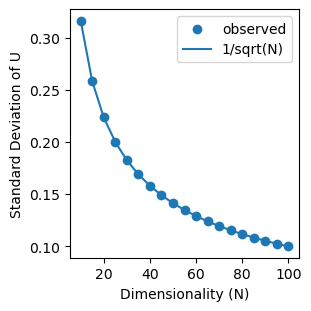

Attempt to measure expected standard deviation of coefficients for random orthonormal matrices


In [196]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout='constrained')
# ax[0].scatter(N, mu)
ax.scatter(N, std, label='observed')
ax.plot(N, 1/np.sqrt(N), label='1/sqrt(N)')
ax.set_xlabel('Dimensionality (N)')
ax.set_ylabel('Standard Deviation of U')
ax.legend(loc='upper right')
savepath = '/Users/landauland/Dropbox/Postdoc/AlignmentProject/mathUpdateFigures'
plt.savefig(savepath+'/u_distribution')

plt.show()


print("Attempt to measure expected standard deviation of coefficients for random orthonormal matrices")

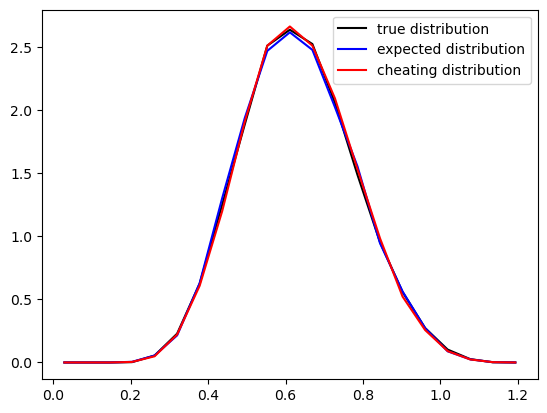

In [197]:
B, N = 10000, 200
num_w = 100

def make_orthonormal(N):
    return torch.linalg.qr(torch.normal(0, 1, (N, N)))[0]

Q = make_orthonormal(N)
D = 1.2**(torch.linspace(1, -N+2, N)) # eigenvalues of X
# S=sqrt(D)
# V=Q
# W = U @ S @ V.T, where U is an (optional) rotation

preloadings = torch.normal(0, 1, (N, B)) # * torch.sqrt(D).view(-1, 1)
w, v = utils.smart_pca(preloadings)
ZCA = v.T @ torch.diag(1/torch.sqrt(w))@v
loadings = ZCA@preloadings
scores = loadings * torch.sqrt(D).view(-1, 1)
X = Q @ scores

w, v = utils.smart_pca(X)

# make weight matrix as rotation of input structure (in X)
use_rotation = True
Us = [make_orthonormal(N) if use_rotation else torch.eye(N) for _ in range(num_w)]
Ws = [U @ torch.diag(torch.sqrt(w)) @ v.T for U in Us]

# measure alignment of W
alignment = np.concatenate([utils.alignment(X.T, W, relative=False) for W in Ws])

dcounts, bins = np.histogram(w, bins=21)
acounts = np.histogram(alignment, bins=bins, density=True)[0]
centers = utils.edge2center(bins)

def expected_alignment_distribution(eigenvalues, use_rotation, valid_rotation=True, bins=11, num_tests=10):
    ecounts, bins = np.histogram(eigenvalues, bins=bins, density=True)
    centers = utils.edge2center(bins)
    if not use_rotation:
        # if no rotation, expected value is just distribution of eigenvalues
        return ecounts, bins, centers
    
    # otherwise, randomly sample using eigenvalue as weighted average
    N = len(eigenvalues)
    eigenvalues = np.tile(eigenvalues.reshape(-1, 1), (1, N*num_tests))
    if valid_rotation:
        mixing = [np.linalg.qr(np.random.normal(0, 1/np.sqrt(N), (N, N)))[0].T for _ in range(num_tests)]
        coefficients = np.concatenate(mixing, axis=1)**2
    else:
        coefficients = np.random.normal(0, 1/np.sqrt(N), (N, N*num_tests))**2
    weights = eigenvalues * coefficients
    alignment = np.average(eigenvalues, axis=0, weights=weights)
    acounts = np.histogram(alignment, bins=bins, density=True)[0]
    return acounts, bins, centers

ecounts = expected_alignment_distribution(w, use_rotation=use_rotation, valid_rotation=False, bins=bins, num_tests=100)[0]
vcounts = expected_alignment_distribution(w, use_rotation=use_rotation, valid_rotation=True, bins=bins, num_tests=100)[0]

figure = plt.figure()
# plt.plot(centers, dcounts, color='k', label="eigenvalue distribution")
plt.plot(centers, acounts, color='k', label="true distribution")
plt.plot(centers, ecounts, color='b', label="expected distribution")
plt.plot(centers, vcounts, color='r', label="cheating distribution")
plt.xlabel('Alignment')
plt.ylabel('Probability')
plt.title('Simulated Alignment')
plt.legend(loc='upper right')
plt.show()

In [1]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model

# Basic alignment_comparison Analyses (or maybe for alignment_stats):
# - compare initial to final alignment...
# - compare initial alignment to delta weight norm...
# - observe alignment of delta weight
# - compare alignment to outgoing delta weight norm!

# Eigenfeature analyses:
# done: - start by just looking at amplitude of activity on each eigenvector within each layer
# done: - Determine contribution of each eigenfeature on performance with a eigenvector dropout experiment
# - Measure beta_adversarial (figure out how adversarial examples map onto eigenvectors)

# forward_eigenvector_dropout is slow... maybe because cpu->gpu overhead? 

# Consider Valentin's idea about measuring an error threshold given signal and noise for a given level of alignment
# e.g. plot a 2d heatmap comparing the noise amplitude and the average alignment
# and then think about how to apply this to network design...

# do alignment stats on MLP-MNIST but with whitened inputs.....

In [2]:
args = ['--network', 'MLP', '--dataset', 'MNIST']
expmt = get_experiment("alignment_stats", build=True, args=args)
nets = expmt.create_networks()[0]
nets = expmt.load_networks(nets)

In [ ]:
import glob
import re
from natsort import natsorted
import torch

# Define the path pattern
path_pattern = r'C:\Users\andrew\Documents\machineLearning\results\alignment_stats\MLP\MNIST\Adam\net_*.pt'

# Get list of matching file paths
file_paths = glob.glob(path_pattern)

# Extract indices from file names
indices = [int(re.search(r'net_(\d+)\.pt', file_name).group(1)) for file_name in file_paths]

# Sort the indices naturally
sorted_indices = natsorted(indices)

# Load the networks into a list in sorted order
networks = [torch.load(file_paths[idx]) for idx in sorted_indices]


In [9]:
model_path = files.results_path() / "alignment_stats"
print(model_path)

C:\Users\andrew\Documents\machineLearning\results


In [9]:
model_name = 'CNN2P2'
dataset_name = 'MNIST'

net = get_model(model_name, build=True, dataset=dataset_name, dropout=0.0, ignore_flag=False)
net.to(DEVICE)

loader_parameters = dict(
    shuffle=True,
)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, loader_parameters=loader_parameters, device=DEVICE)

In [242]:
# test "alignment" metric of Maennel
def metric(data, weight):
    # data is (batch, D)
    # weight is (M, D)
    # measures  sum_i sqrt((vi'Svi).(vi'S-1vi)) where S is W'W and vi are eigenvectors of D'D
    S = torch.cov(weight.T)
    Sinv = torch.linalg.pinv(S)
    _, _, v = torch.linalg.svd(data, full_matrices=False)
    upper = torch.sum((v @ S) * v, dim=1)
    lower = torch.sum((v @ Sinv) * v, dim=1)
    return torch.mean(torch.sqrt(upper*lower)) - 1

def misalignment(data, weight):
    pass

B, M, D = 10000, 50, 100
k = min(B, D)

# create eigenstructure
E = 1.1**(torch.linspace(1, -D+2, D))
V = torch.linalg.qr(torch.normal(0, 1, (D, D)))[0]
loading = torch.normal(0, 1, (B, D)) * torch.sqrt(E)
data = loading @ V.T

w, v = utils.smart_pca(data.T)
U, S, Vt = torch.linalg.svd(data, full_matrices=False)

beta = torch.normal((E**6).view(-1, 1).expand(-1, M), 0.1)
weight = (V @ beta).T
weight_aligned = Vt
random_basis = torch.linalg.qr(torch.normal(0, 1, (D, D)))[0]
weight_random = torch.normal(0, 1, (D, D)) @ random_basis

# p = np.linspace(0, 1, 101)
# m = np.zeros(101)
# for ii, pp in enumerate(p):
#     weight_partial = pp * weight_aligned + (1 - pp) * weight_random
#     m[ii] = metric(data, weight_partial)

print(weight.shape, weight_aligned.shape, weight_random.shape)

print(metric(data, weight))
print(metric(data, weight_aligned))
print(metric(data, weight_random))
# print(metric(data, weight_partial))
# plt.plot(p, m)
# plt.show()


torch.Size([50, 100]) torch.Size([100, 100]) torch.Size([100, 100])
tensor(-0.3147)
tensor(-0.0100)
tensor(7.8174)


In [230]:
w, v = utils.smart_pca(data.T)

In [246]:
weight.shape

torch.Size([50, 100])

In [247]:
C = torch.cov(data.T)
Cinv = torch.linalg.inv(C)

VDV = v @ torch.diag(w) @ v.T
VDVinv = v @ torch.diag(1/w) @ v.T

ii = 0

for ii, vv in enumerate(v.T):
    upper = np.array(vv @ VDV @ vv.T)
    lower = np.array(vv @ VDVinv @ vv.T)
    print(ii, upper*lower, "       ", upper, lower, np.array(w[ii]), np.array(1/w[ii]))
    if ii > 10: break


print('')

for ii, vd in enumerate(weight):
    upper = np.array(vd @ VDV @ vd.T)
    lower = np.array(vd @ VDVinv @ vd.T)
    print(ii, upper*lower, "       ", upper, lower)
    if ii > 10: break

0 0.9999701         1.0791082 0.9266634 1.0791074 0.92669183
1 0.99997514         1.0194153 0.98093015 1.0194142 0.98095554
2 0.99997425         0.91170317 1.09682 0.9117031 1.0968482
3 1.0000418         0.8340938 1.198956 0.834094 1.1989057
4 0.99999744         0.7705323 1.2978008 0.77053106 1.2978063
5 0.9999925         0.676635 1.4778905 0.6766347 1.4779023
6 1.0000225         0.6201958 1.6124303 0.6201947 1.612397
7 0.99996656         0.57039344 1.7531172 0.5703924 1.7531791
8 1.0000181         0.5171787 1.9336026 0.51717836 1.933569
9 1.0000385         0.46746764 2.139268 0.46746773 2.1391852
10 1.0000231         0.42636058 2.3454869 0.4263604 2.3454335
11 0.9999852         0.38485694 2.5983298 0.38485655 2.5983708

0 3950.5066         4.4512453 887.5059
1 5006.1846         4.6987267 1065.4343
2 6044.5693         3.9549725 1528.3467
3 6011.3228         5.9154806 1016.2019
4 5184.68         4.465582 1161.0312
5 4436.157         4.6420507 955.646
6 5296.763         4.8301067 1096.61

In [210]:
beta.shape

torch.Size([100, 50])

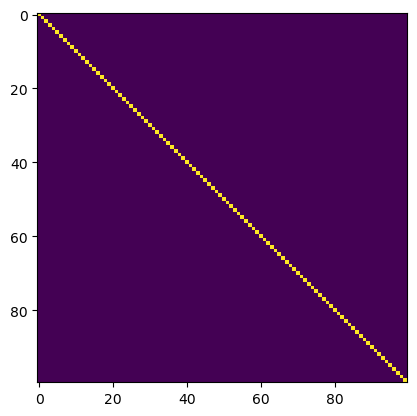

In [115]:
S = torch.cov(weight.T)
Sinv = torch.linalg.inv(S)
plt.imshow(S @ Sinv)